# データ科学展望2 最終レポート

0530-32-3973 竹田航太

## Kalman Filterを実データに適用して解析する．
データ: 
OANDA APIにより為替データを取得
- USD/JPY
- 買値終値
- 2014-01-01~2018-12-30

https://developer.oanda.com/docs/jp/

別の授業でfxデータの予測を試みているところなのでそのデータに対して成分分解モデルを適用して解析を行います，



## 成分分解モデル

参考:
- 京都大学大学院講義「データ科学展望2」

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def load_fx_data(instrument_list, data_kind='train'):
    """
    fxデータをローカルから読み込み．
    args:
        - instrument_list: 文字配列, 為替ペア名の配列('USD_JPY', 'GBP_JPY', 'EUR_JPY')
        - data_kind: 読み込みたいデータの種類．('train', 'test')
    return:
        df_fict: dict, 為替ペア名をkeyとしたfxデータの辞書
    """
    df_dict = {}
    for instrument in instrument_list:
        df = pd.read_csv(f'data/fx_data_{instrument}_{data_kind}', index_col=0, header=0)
        df.index = pd.to_datetime(df.index)
        df_dict[instrument] = df
    return df_dict

In [4]:
instrument_list = ['USD_JPY']

df_dict_train = load_fx_data(instrument_list, data_kind='train')

df_dict_train['USD_JPY']

,Open_ask,High_ask,Low_ask,Close_ask,Volume,Open_bid,High_bid,Low_bid,Close_bid
Time,,,,,,,,,
2014-01-01 22:00:00+00:00,105.270,105.451,104.554,104.837,76933,105.221,105.436,104.542,104.782
2014-01-02 22:00:00+00:00,104.839,104.909,104.083,104.868,64141,104.785,104.872,104.070,104.834
2014-01-05 22:00:00+00:00,104.846,104.961,103.920,104.230,78448,104.801,104.943,103.906,104.204
2014-01-06 22:00:00+00:00,104.230,104.742,104.184,104.623,66801,104.206,104.730,104.141,104.577
2014-01-07 22:00:00+00:00,104.623,105.132,104.603,104.878,74924,104.579,105.117,104.457,104.836
...,...,...,...,...,...,...,...,...,...
2018-12-23 22:00:00+00:00,111.002,111.198,110.277,110.485,31727,110.912,111.184,110.261,110.424
2018-12-25 22:00:00+00:00,110.485,111.418,110.154,111.381,22247,110.424,111.402,110.124,111.353
2018-12-26 22:00:00+00:00,111.339,111.375,110.463,111.003,44568,111.289,111.334,110.449,110.956


USD/JPYの買値の終値をtrainとする．

In [5]:
train = df_dict_train['USD_JPY']['Close_ask'].values
N = train.shape[0]

## 解析
fxデータに周期性は見られないので良い結果は得られない可能性が高い．

In [22]:
# ハイパーパラメータの設定
sd_sys_t = 0.02 #システムノイズにおけるトレンド成分の標準偏差の推定値
sd_sys_s = 0.1 #システムノイズにおける周期成分(季節成分)の標準偏差の推定値
sd_obs = 0.1 #観測ノイズの標準偏差の推定値
tdim = 2 #トレンドモデルの次元
period = 500 #周期の推定値
pdim = period - 1 #周期変動モデルの次元

#トレンドモデル
F1 = np.array([[2, -1], [1, 0]])
G1 = np.array([[1], [0]])

#トレンドモデルの観測モデル
H1 = np.array([[1, 0]])

#周期変動モデル
a = np.ones(pdim).reshape(-1,1)
F2 = np.block([a, np.vstack([np.eye(pdim-1), np.zeros((1, pdim-1))])]).T
G2 = np.zeros((pdim, 1))
G2[0,0] = 1

#周期変動モデルの観測モデル
H2 = np.zeros((1, pdim))
H2[0,0] = 1

#モデル全体
#システムモデル
F = np.block([[F1, np.zeros((tdim, pdim))], [np.zeros((pdim,tdim)), F2]])
G = np.block([[G1, np.zeros((tdim,1))], [np.zeros((pdim,1)), G2]])
Q = np.array([[sd_sys_t**2, 0], [0, sd_sys_s**2]])
#観測モデル
H = np.block([[H1, H2]])
R = np.array([[sd_obs**2]])

#状態変数などの定義
#データに関係ない初期値を格納するため N+1 個の配列を確保
dim = tdim + pdim #状態変数の次元
xp = np.zeros((N+1, dim, 1)) #予測分布の平均値
xf = np.zeros((N+1, dim, 1)) #フィルタ分布の平均値
Vp = np.zeros((N+1, dim, dim)) #予測分布の分散
Vf = np.zeros((N+1, dim, dim)) #フィルタ分布の分散
K = np.zeros((N+1, dim, 1)) #カルマンゲイン
# (注意) 予測分布の初期値を0としたことになっている

In [23]:
y  = train
for t in range(1, N+1):
    #一期先予測
    xp[t] = F@xf[t-1]
    Vp[t] = F@Vf[t-1]@F.transpose() + G@Q@G.transpose()
    
    #フィルタ
    K[t] = Vp[t]@H.transpose()@np.linalg.inv(H@Vp[t]@H.transpose()+R)
    xf[t] = xp[t] + K[t]@(y[t-1]-H@xp[t])
    Vf[t] = (np.eye(dim)-K[t]@H)@Vp[t]

In [24]:
# フィルタ分布の初期値を削除
xf = np.delete(xf, 0, 0)
Vf = np.delete(Vf, 0, 0)

# トレンド成分の平均値を抽出
x_tr_mean = xf[:,0,0]

# 周期成分の平均値を抽出
x_per_mean = xf[:,tdim,0]

# 状態の平均値を抽出
x_mean = xf[:,0,0] + xf[:,tdim,0]

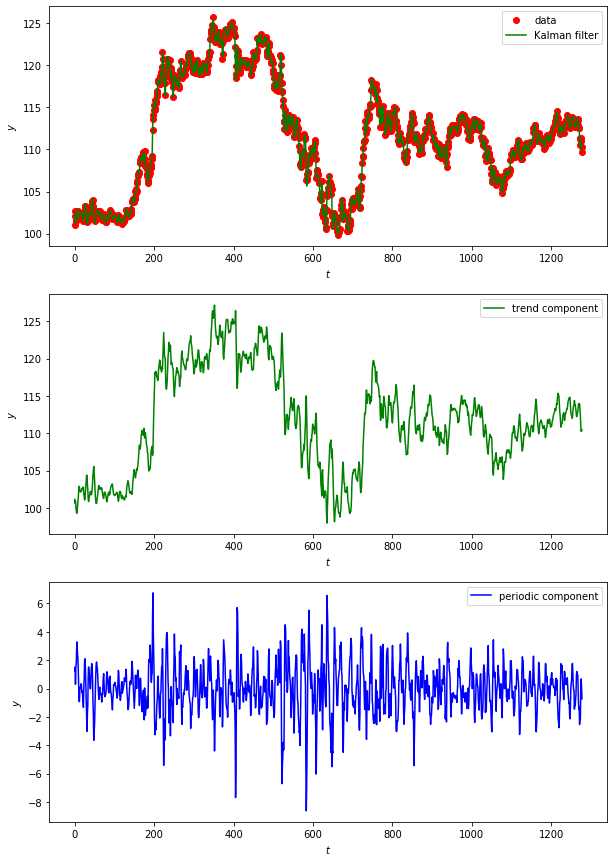

In [25]:
# 結果の可視化
start = 20
fig, ax = plt.subplots(3, 1, figsize=(10,15))
ax[0].plot(y[start:], 'ro', label='data')
ax[0].plot(x_mean[start:], 'g-', label='Kalman filter')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y$')
ax[0].legend()

ax[1].plot(x_tr_mean[start:], 'g-', label='trend component')
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$y$')
ax[1].legend()

ax[2].plot(x_per_mean[start:], 'b-', label='periodic component')
ax[2].set_xlabel('$t$')
ax[2].set_ylabel('$y$')
ax[2].legend()
plt.show()